## Notebook is still under construction
### Dataset Link-
https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("DailyDelhiClimateTrain.csv", index_col="date", parse_dates=True)
train.index.freq = 'D'

In [3]:
test = pd.read_csv("DailyDelhiClimateTest.csv", index_col="date", parse_dates=True)
test.index.freq = 'D'

In [4]:
train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [5]:
train.dtypes

meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

<AxesSubplot:xlabel='date'>

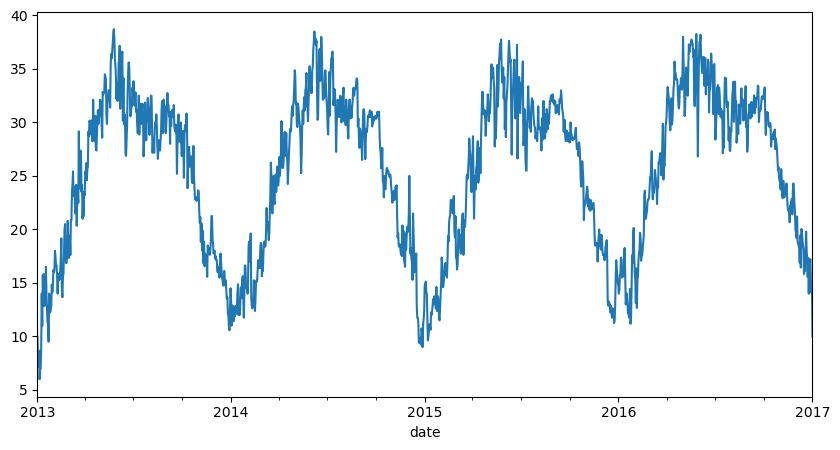

In [6]:
train['meantemp'].plot(figsize=(10,5))

In [7]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

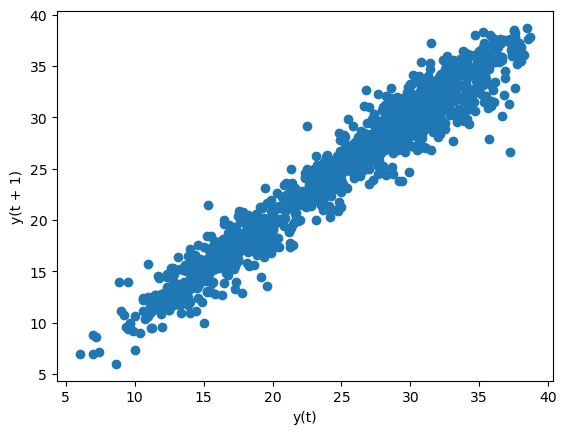

In [8]:
lag_plot(train['meantemp'])

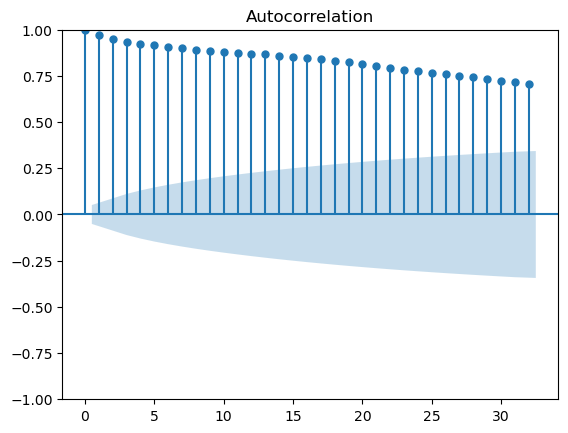

In [9]:
plot_acf(train['meantemp']);
#There is clear indication of the seasonality in the data

c:\Users\admin\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


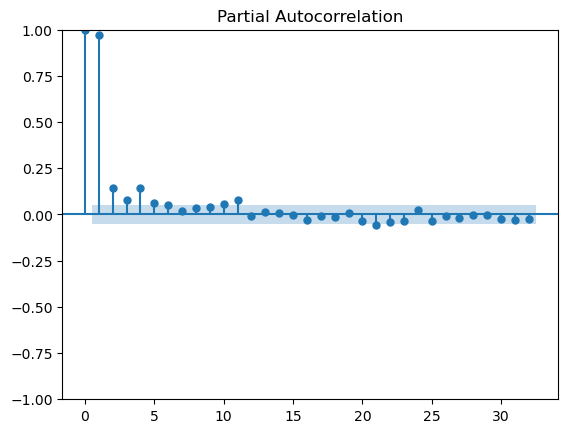

In [10]:
plot_pacf(train['meantemp']);

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
# we will check for the stationarity of the series
# we will make a function so that interpretation of the test will be a little easy

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [13]:
adf_test(train['meantemp'])     

Augmented Dickey-Fuller Test: 
ADF test statistic        -2.021069
p-value                    0.277412
# lags used               10.000000
# observations          1451.000000
critical value (1%)       -3.434865
critical value (5%)       -2.863534
critical value (10%)      -2.567832
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [77]:
from pmdarima import auto_arima

In [79]:
stepwise_fit = auto_arima(y = train['meantemp'],X=train.drop(columns=['meantemp']), d=2,error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=500,m=4,stationary=False,test='adf')

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=16.22 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=5820.926, Time=1.67 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=5522.005, Time=1.00 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=3.37 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=5520.901, Time=0.95 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=5522.039, Time=1.85 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=5523.728, Time=2.45 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=5394.851, Time=1.43 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=5396.867, Time=3.97 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=5396.847, Time=6.47 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=5398.984, Time=6.63 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=5241.995, Time=4.45 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=5089.472, Time=11.20 sec
 ARIMA(3,2,0)(2,0,0)[4]             : AIC=4996.299, Time=14.26 sec
 ARIMA(3,2,0)(2,0,1)[4]             : AI

In [57]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1462
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2768.239
Date:                Thu, 19 Jan 2023   AIC                           5542.478
Time:                        10:02:46   BIC                           5558.339
Sample:                             0   HQIC                          5548.395
                               - 1462                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5728      0.046     12.494      0.000       0.483       0.663
ma.L1         -0.8028      0.036    -22.070      0.000      -0.874      -0.731
sigma2         2.5896      0.072     36.204      0.000       2.449       2.730
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               255.47
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.46
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX 

In [75]:
model = ARIMA(train['meantemp'], order = (1,1,1)).fit()

In [66]:
start = len(train)
end = len(train) + len(test) - 1

In [67]:
predictions = model.predict(start, end, typ = 'levels').rename("ARIMA (1,1,1) Predictions")

<AxesSubplot:xlabel='date'>

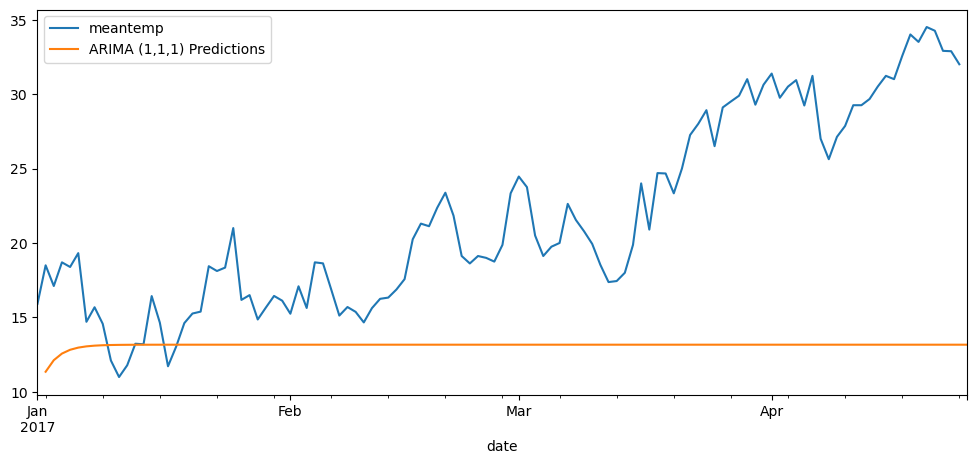

In [68]:
test['meantemp'].plot(figsize=(12,5), legend= True)
predictions.plot(legend = True)

In [49]:
test['meantemp'].mean()

21.71307892022824

In [50]:
predictions.mean()

13.13305376793538

In [88]:
train_transformed = train.diff().dropna()

In [89]:
 for i in train_transformed.columns:
    adf_test(train_transformed[i], title = i)
    print("-"*30)

Augmented Dickey-Fuller Test: meantemp
ADF test statistic     -1.637872e+01
p-value                 2.764863e-29
# lags used             9.000000e+00
# observations          1.451000e+03
critical value (1%)    -3.434865e+00
critical value (5%)    -2.863534e+00
critical value (10%)   -2.567832e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
------------------------------
Augmented Dickey-Fuller Test: humidity
ADF test statistic     -1.268353e+01
p-value                 1.172923e-23
# lags used             1.400000e+01
# observations          1.446000e+03
critical value (1%)    -3.434880e+00
critical value (5%)    -2.863541e+00
critical value (10%)   -2.567835e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
------------------------------
Augmented Dickey-Fuller Test: wind_speed
ADF test statistic     -1.283772e+01
p-value                 5.693419e-24
# lag

In [92]:
from statsmodels.tsa.vector_ar.var_model import VAR
## Gridsearch for order p AR of VAR model
model = VAR(train_transformed)
for p in range(1,8):
    results = model.fit(p)
    print(f"order {p}")
    print(f"AIC: {results.aic}")

order 1
AIC: 18.41355619482598
order 2
AIC: 18.168999334323484
order 3
AIC: 18.005324447996752
order 4
AIC: 17.92889432090961
order 5
AIC: 17.881287997502355
order 6
AIC: 17.85756143526391
order 7
AIC: 17.839411367430987


In [93]:
results = model.fit(5)

In [94]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 19, Jan, 2023
Time:                     15:37:09
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    18.1861
Nobs:                     1456.00    HQIC:                   17.9950
Log likelihood:          -21197.5    FPE:                5.83107e+07
AIC:                      17.8813    Det(Omega_mle):     5.50645e+07
--------------------------------------------------------------------
Results for equation meantemp
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.006139         0.042170            0.146           0.884
L1.meantemp            -0.185894         0.035367           -5.256           0.000
L1.humidity             0.007434         0.007456

In [95]:
train.tail()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762
2016-12-31,15.052632,87.000000,7.325000,1016.100000
2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [107]:
test = test.drop('2017-01-01')

In [109]:
lagged_values = train.values[-5:]

In [110]:
z = results.forecast(y = lagged_values,steps=len(test))

In [111]:
idx = pd.date_range('2017-01-01', periods= len(test), freq= 'D')

In [112]:
df_forecast = pd.DataFrame(data= z, index = idx,columns= [i+'_1d' for i in train_transformed.columns])

In [113]:
df_forecast.head()

,meantemp_1d,humidity_1d,wind_speed_1d,meanpressure_1d
2017-01-01,-9.462405,-56.265622,-1.043473,-2315.810230
2017-01-02,-5.335153,-67.083033,15.858564,471.463555
2017-01-03,-2.273137,-23.491937,-1.693307,638.648678
2017-01-04,2.389710,7.257241,-7.378716,-86.858318
2017-01-05,3.008603,14.740641,-1.255060,-78.342252
